In [1]:
import os

from PIL import Image
from sklearn.model_selection import train_test_split

%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

seed=42

In [2]:
lr = 0.003
batch_size = 64
epochs = 25

25

In [3]:
# Either convert everything to RGB & same size, or drop 'unaligned' images
def cross_reference_files_dropping_unaligned(input_imgs, label_imgs):
    ret_input_imgs = []
    ret_label_imgs = []
    for input_img_fp, label_img_fp in zip(input_imgs, label_imgs):
        assert os.path.basename(input_img_fp) == os.path.basename(label_img_fp), f"{input_img_fp} != {label_img_fp}. Are your files sorted & named the same?"
        input_img = Image.open(input_img_fp)
        label_img = Image.open(label_img_fp)
        if input_img.size != label_img.size:
            print(f"{input_img_fp} and {label_img_fp} are not the same size. Skipping.")
            continue
        if input_img.mode != label_img.mode:
            print(f"{input_img_fp} and {label_img_fp} are not the same mode. Skipping.")
            continue
        ret_input_imgs.append(input_img_fp)
        ret_label_imgs.append(label_img_fp)

    assert len(ret_input_imgs) == len(ret_label_imgs)
    return ret_input_imgs, ret_label_imgs

In [4]:
base_data_dir = '../data'

input_imgs = sorted([os.path.join(base_data_dir, 'unshiny', fname) for fname in os.listdir(os.path.join(base_data_dir, 'unshiny')) if fname.endswith('.png')])
label_imgs = sorted([os.path.join(base_data_dir, 'shiny', fname) for fname in os.listdir(os.path.join(base_data_dir, 'shiny')) if fname.endswith('.png')])

print(f'Found {len(input_imgs)} images before cross referencing')

# input_imgs, label_imgs = cross_reference_files_dropping_unaligned(input_imgs, label_imgs)

assert len(input_imgs) == len(label_imgs)
assert all(os.path.basename(input_img) == os.path.basename(label_img) for input_img, label_img in zip(input_imgs, label_imgs))

print(f'Found {len(input_imgs)} images after cross referencing')

Found 12239 images before cross referencing
Found 12239 images after cross referencing


In [5]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_imgs, label_imgs, test_size=0.2, random_state=seed)

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
class AutoEncoderDataset(Dataset):
    def __init__(self, input_imgs, label_imgs, transforms=None):
        assert len(input_imgs) == len(label_imgs)
        # not supporting LA mode images
        # self.input_imgs = [img for img in input_imgs if Image.open(img).mode != 'LA']
        # self.label_imgs = [img for img in label_imgs if Image.open(img).mode != 'LA']
        self.input_imgs = [Image.open(img).convert('RGB') for img in input_imgs]
        self.label_imgs = [Image.open(img).convert('RGB') for img in label_imgs]
        self.transforms = transforms

        assert len(self.input_imgs) == len(self.label_imgs)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        # input_img = Image.open(self.input_imgs[idx]).convert('RGB')
        # label_img = Image.open(self.label_imgs[idx]).convert('RGB')
        return self.transforms(self.input_imgs[idx]), self.transforms(self.label_imgs[idx])
    def __len__(self):
        return len(self.input_imgs)
        pa

In [8]:
ideal_imsize = (80, 80)
transforms = transforms.Compose([
    transforms.Resize(ideal_imsize),
    transforms.ToTensor()
])

train_ds = AutoEncoderDataset(train_inputs, train_labels, transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# TODO: add validation dataset

test_ds = AutoEncoderDataset(test_inputs, test_labels, transforms)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

/home/lucaskeller/anaconda3/envs/ai2024/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# class AutoEncoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, default_activation=nn.ReLU(), latent_dim=512):
#         super(AutoEncoder, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels, 64, 5, stride=2, padding=2),  # 64x64 -> 32x32
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
#             nn.BatchNorm2d(64),
#             default_activation,
#         )

#         self.latent = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * 32 * 32, latent_dim),
#             default_activation,
#             nn.Linear(latent_dim, 64 * 32 * 32),
#             default_activation,
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.ConvTranspose2d(64, out_channels, 5, stride=2, padding=2, output_padding=1),  # Adjusted padding and output_padding
#             # nn.BatchNorm2d(3),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.latent(x)
#         x = x.view(-1, 64, 32, 32)
#         x = self.decoder(x)
#         return x

In [10]:
# class AutoEncoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, default_activation=nn.ReLU(), latent_dim=512):
#         super(AutoEncoder, self).__init__()
        
#         self.encoder = nn.Sequential

#         self.latent = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * 32 * 32, latent_dim),
#             default_activation,
#             nn.Linear(latent_dim, 64 * 32 * 32),
#             default_activation,
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             default_activation,
#             nn.ConvTranspose2d(64, out_channels, 5, stride=2, padding=2, output_padding=1),  # Adjusted padding and output_padding
#             # nn.BatchNorm2d(3),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.latent(x)
#         x = x.view(-1, 64, 32, 32)
#         x = self.decoder(x)
#         return x

In [11]:
# class AutoEncoder(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, default_activation=nn.ReLU(), latent_dim=256):
#         super(AutoEncoder, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels, 64, 5, stride=2, padding=2),  # 64x64 -> 32x32
#             default_activation,
#             nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
#             default_activation,
#             nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
#             default_activation,
#             nn.Conv2d(64, 128, 3, stride=1, padding=1), # 32x32 -> 32x32
#             default_activation,
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             default_activation,
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             default_activation,
#             nn.Conv2d(128, 256, 3, stride=2, padding=1), # 32x32 -> 16x16
#             default_activation,
#             nn.Conv2d(256, 256, 3, stride=1, padding=1), # 16x16 -> 16x16
#             default_activation,
#             nn.Conv2d(256, 512, 3, stride=1, padding=1),
#             default_activation,
#             nn.Conv2d(512, 512, 3, stride=1, padding=1),
#             default_activation,
#         )

#         self.latent = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512 * 16 * 16, latent_dim),
#             default_activation,
#             nn.Linear(latent_dim, 512 * 16 * 16),
#             default_activation,
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Adjusted output padding
#             default_activation,
#             nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
#             default_activation,
#             nn.ConvTranspose2d(64, out_channels, 5, stride=2, padding=2, output_padding=1),  # Adjusted padding and output_padding
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.latent(x)
#         x = x.view(-1, 512, 16, 16)
#         x = self.decoder(x)
#         return x

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.dropout_percentage = 0.5
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.resblock1 = self._make_layer(64, 64, 2)
        self.resblock2 = self._make_layer(64, 128, 2, stride=2)
        
        # Calculate the output size after all convolutions and pooling
        # Initial size: 80
        # After conv1 and maxpool1: floor((80 - 7 + 2*3)/2 + 1) / 2 = 20
        # After resblock2 with stride=2: floor((20 - 1)/2 + 1) = 10 (each resblock without stride keeps size same)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc_mu = nn.Linear(512, 256)
        self.fc_logvar = nn.Linear(512, 256)
        
        # Decoder
        self.fc2 = nn.Linear(256, 128 * 10 * 10)
        self.dec_resblock2 = self._make_layer(128, 128, 2, upsample=True)
        self.dec_resblock1 = self._make_layer(128, 64, 2, upsample=True)
        
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.final_deconv = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1, upsample=False):
        layers = []
        for i in range(num_blocks):
            if i == 0 and not upsample:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
            elif i == 0 and upsample:
                layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
            else:
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=self.dropout_percentage))
        return nn.Sequential(*layers)

    def encode(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = z.view(-1, 128, 10, 10)
        z = self.dec_resblock2(z)
        z = self.dec_resblock1(z)
        z = self.final_upsample(z)
        z = self.sigmoid(self.final_deconv(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Example usage:
model = AutoEncoder()
print(model)

AutoEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (resblock1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
  )
  (resblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dro

In [13]:
reconstruction_function = nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)  # MSE loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [14]:
model = AutoEncoder().to(device)
print(f"{sum([x.numel() for x in model.parameters()])} model parameters")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = loss_function

10828099 model parameters


<function __main__.loss_function(recon_x, x, mu, logvar)>

In [15]:
import time
model.train()

start_time = time.time()
for epoch in range(epochs):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = criterion(recon_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        train_loss += loss.item()
        
        if i % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dl)}, Loss: {loss.item() / len(inputs):.4f}')
    
    # print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dl):.4f}, Time: {time.time() - start_time:.2f}s')

print(f'Training finished, Time: {time.time() - start_time:.2f}s')
print(f'Average time per epoch: {(time.time() - start_time) / epochs:.2f}s')

Epoch 1/25, Batch 1/153, Loss: 3939.1694
Epoch 1/25, Batch 101/153, Loss: 1292.8564
Epoch 2/25, Batch 1/153, Loss: 1734.0908
Epoch 2/25, Batch 101/153, Loss: 1221.8754
Epoch 3/25, Batch 1/153, Loss: 1096.9073
Epoch 3/25, Batch 101/153, Loss: 1015.6762
Epoch 4/25, Batch 1/153, Loss: 1150.4889
Epoch 4/25, Batch 101/153, Loss: 1001.4950
Epoch 5/25, Batch 1/153, Loss: 906.7774
Epoch 5/25, Batch 101/153, Loss: 936.1535
Epoch 6/25, Batch 1/153, Loss: 908.0624
Epoch 6/25, Batch 101/153, Loss: 923.7499
Epoch 7/25, Batch 1/153, Loss: 858.5061
Epoch 7/25, Batch 101/153, Loss: 825.3658
Epoch 8/25, Batch 1/153, Loss: 960.5696
Epoch 8/25, Batch 101/153, Loss: 884.1198
Epoch 9/25, Batch 1/153, Loss: 925.9891
Epoch 9/25, Batch 101/153, Loss: 823.4561
Epoch 10/25, Batch 1/153, Loss: 838.7684
Epoch 10/25, Batch 101/153, Loss: 876.9092
Epoch 11/25, Batch 1/153, Loss: 772.8080
Epoch 11/25, Batch 101/153, Loss: 883.8005
Epoch 12/25, Batch 1/153, Loss: 739.1759
Epoch 12/25, Batch 101/153, Loss: 738.5508
Ep

NameError: name 'outputs' is not defined

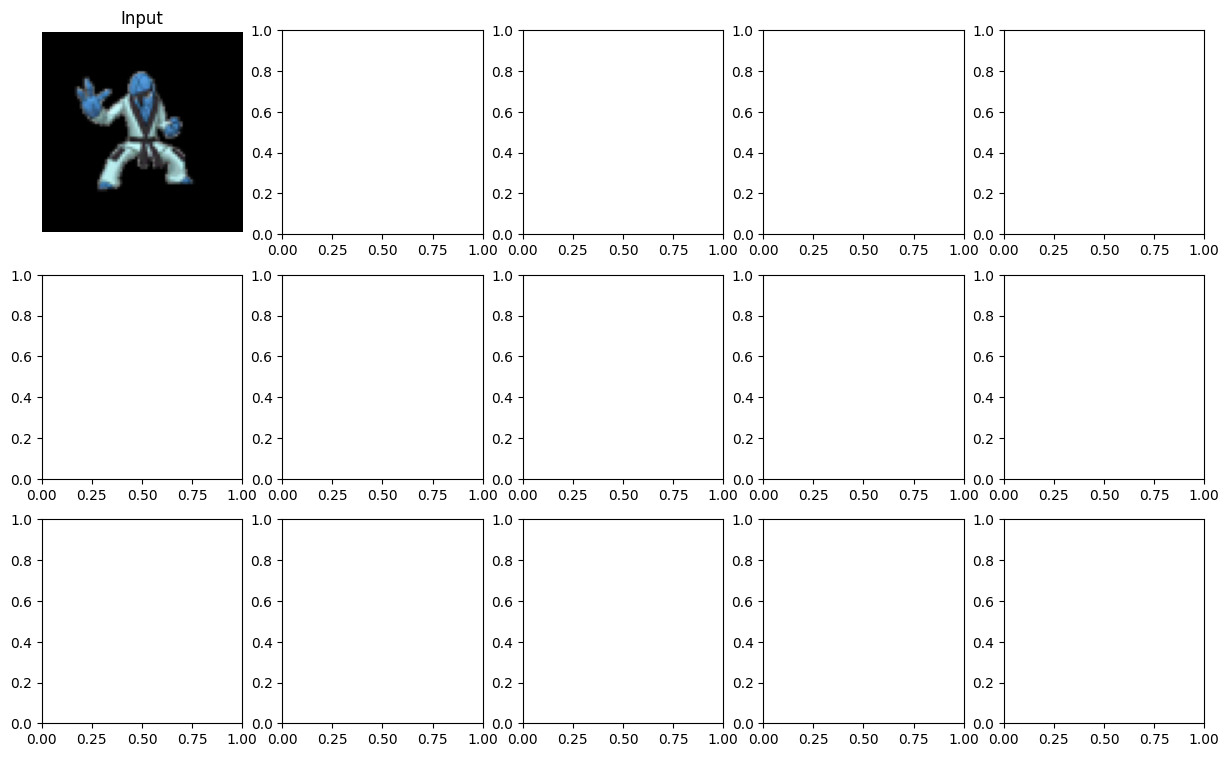

In [18]:
import torch
import torch
model.eval()

def show_model_performance(model, test_dl, device):
    total_loss = 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            recon_batch, mu, logvar = model(inputs)
            loss = criterion(recon_batch, inputs, mu, logvar)
            # outputs = model(inputs)
            # loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_dl)
    print(f"Average Loss on Test Set: {avg_loss:.5f}")


import matplotlib.pyplot as plt

def show_autoencoder_output(test_dl, model):
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # outputs = model(inputs)
            recon_batch, mu, logvar = model(inputs)
            loss = criterion(recon_batch, inputs, mu, logvar)

            inputs = inputs.cpu().numpy()
            recon_batch = recon_batch.cpu().numpy()
            labels = labels.cpu().numpy()

            # Plot the input, output, and ground truth images
            fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

            for i in range(5):
                axes[0, i].imshow(inputs[i].transpose(1, 2, 0))
                axes[0, i].set_title("Input")
                axes[0, i].axis("off")

                axes[1, i].imshow(recon_batch[i].transpose(1, 2, 0))
                axes[1, i].set_title("Output")
                axes[1, i].axis("off")

                axes[2, i].imshow(labels[i].transpose(1, 2, 0))
                axes[2, i].set_title("Ground Truth")
                axes[2, i].axis("off")

            plt.tight_layout()
            plt.show()
            break


show_autoencoder_output(test_dl, model)
show_model_performance(model, test_dl, device)